### Import packages and modules

In [1]:
using PyCall
using PyPlot
plt = pyimport("matplotlib.pyplot")

using Mimi
# include code of main model file, in which the module MimiDICE2016R2_opt is defined
include("../src/MimiDICE2016R2.jl")
# load module MimiDICE2016R2_opt with the respective exported functions constructdice, get_model, optimise_model
using Main.OptMimiDICE2016R2

### Define functions

In [2]:
# evaluate variables written in vars for model runs written on run of model m and add them to dictionary results
function get_results(m::Model, vars::Vector, results::Dict, run::String)
    for i in 1:length(vars)
        results[join([run, String(vars[i][2])], "_")] = m[vars[i][1], vars[i][2]]
    end
    return results
end;

In [3]:

# get a list of result keys as strings, based on model runs and variables, such that one can pass these to a plotting function for selective plotting
function get_result_keys(runs, vars)
    result_keys = []
    for i in 1:length(vars)
        for j in 1:length(runs)
            result_keys = push!(result_keys, join([runs[j], vars[i]], "_")) # previously String(vars[j][2])
        end
    end
    return result_keys
end;

In [22]:
# get a tuple of ylabel and ylims
function get_labels_lims(var)
    if var=="MIU"
        yll = ("Emission control rate MIU", (-0.2, 1.3))
    elseif var=="E"
        yll = ("Emissions E [Gt CO\$_2\$]", (-20, 80))
    elseif var=="CPRICE"
        yll = ("Carbon price CPRICE [USD per Gt CO\$_2\$]", (0, 200))
    elseif var=="ABATECOST"
        yll = ("Mitigation cost ABATECOST [USD per Gt CO\$_2\$?]", (0, 200))
    else
        println("Unknown variable to plot")
        yll = ("", ())
    end
    return yll
end;

In [5]:

# plot selective results, as indicated by result_keys, from result dictionary results
# supposed to work with up to two plotted variables on the axes - might need continuous updating for different labels
function plot_results(results, result_keys, vars, xlims=())
    fig = plt.figure(figsize=(10, 5))
    ax  = fig.add_subplot(111)
    ax.grid()
    
    xlabel="Year"
    yll1 = get_labels_lims(vars[1])

    if xlims == ()
        xlims = (2015, 2505)
    end

    ax.set_xlabel(xlabel)
    ax.set_ylabel(yll1[1])
    ax.set_xlim(xlims)
    ax.set_ylim(yll1[2])

    # variable that determines how many trajectories are plotted on first ax
    # initially assume only one plotted variable
    n_traj = length(result_keys)

    if length(vars) == 2
        yll2 = get_labels_lims(vars[2])
        ax2 = ax.twinx()
        ax2.set_ylabel(yll2[1])
        ax2.set_ylim(yll2[2])
        n_traj = Int(length(result_keys)/2)
    end

    for k in 1:n_traj
        key = result_keys[k]
        ax.plot(t, results[key], label=key)
    end

    if length(vars) == 2
        for k in n_traj+1:length(result_keys)
            key = result_keys[k]
            ax2.plot(t, results[key], ":", label=key)
        end
    end 

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(vcat(lines, lines2), vcat(labels, labels2), loc=1)
    
    display(plt.gcf())
end;


### Get models

In [10]:
# Get standard DICE2016R2 baseline model
m_base = get_model()
time_steps = length(OptMimiDICE2016R2.model_years)
t = collect(OptMimiDICE2016R2.model_years)
run(m_base);

In [7]:
# Get standard DICE optimised model
m_opt = optimise_model();

In [9]:
# set damages to zero and get NoDam model
m_nodam = get_model()
update_param!(m_nodam, :damages, :a2, 0)
run(m_nodam)
optimise_model(m_nodam);

### Evaluate models

In [13]:
eval_vars = [   [:neteconomy, :CPRICE],
                [:emissions, :E],
                [:neteconomy, :MIU],
                [:neteconomy, :ABATECOST]
];

In [15]:
results = Dict()
results = get_results(m_base, eval_vars, results, "base")
results = get_results(m_opt, eval_vars, results, "opt");
results = get_results(m_nodam, eval_vars, results, "nodam");

### Plot results

In [18]:
plot_runs = ["base", "opt", "nodam"]
plot_vars = ["MIU", "E"]
result_keys = get_result_keys(plot_runs, plot_vars);

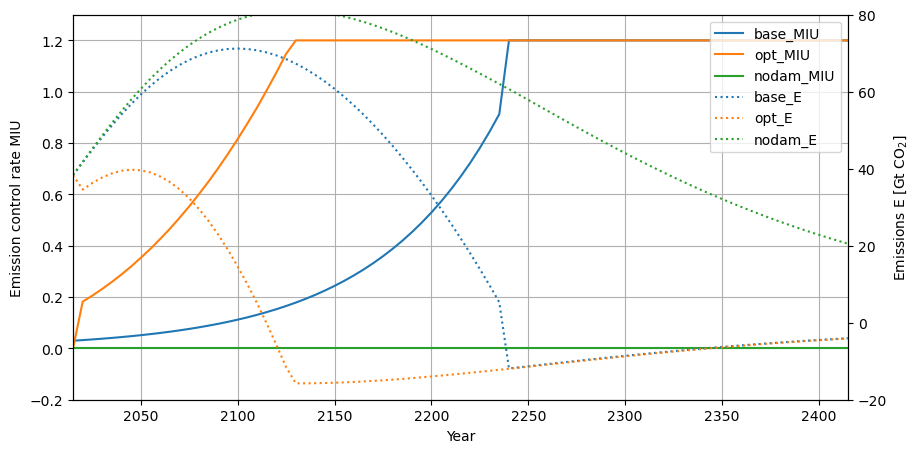

In [23]:
plot_results(results, result_keys, plot_vars, (2015, 2415))